#  제 13 주. 의사결정트리와 ccp_alpha

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, classification_report

from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
from joblib import dump, load

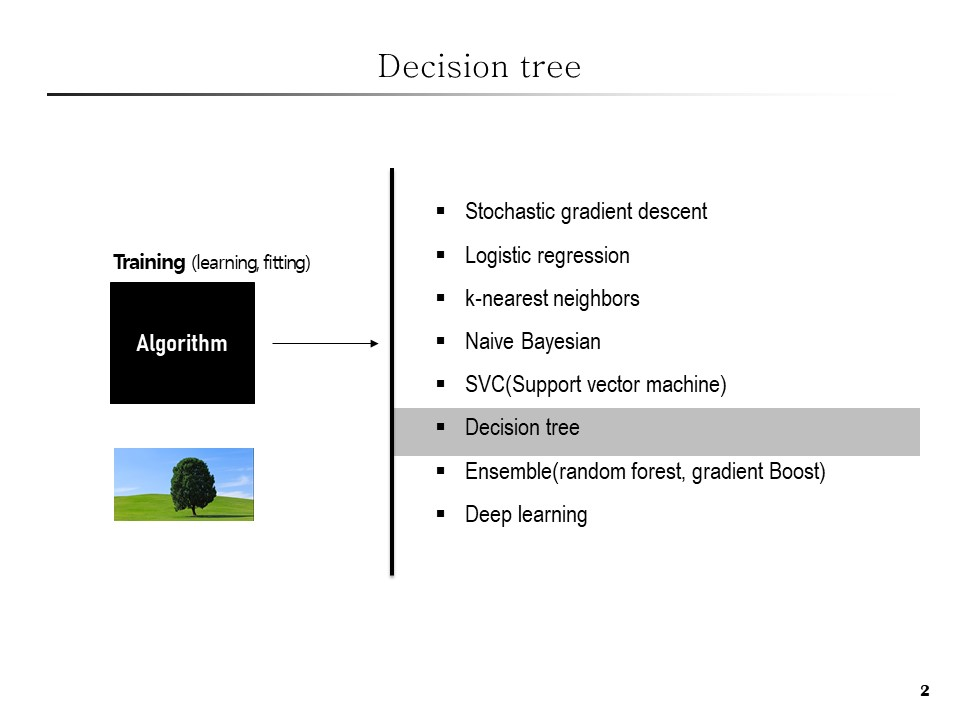

In [6]:
from IPython.display import Image
width=700; height=500
Image(filename='../image/ensemble/슬라이드2.jpg', width=width, height=height)

## 의사결정 트리 (CHAID, C4.5, C5.0, CART)
### 1. 쉽다
### 2. 실용적이다(데이터전처리를 대충한다. No 표준화, No 결측치)
### 3. 유연하다(수치형/범주형을 모두 다룬다)
### 4. 스무고개 방식(Split & Pruning)

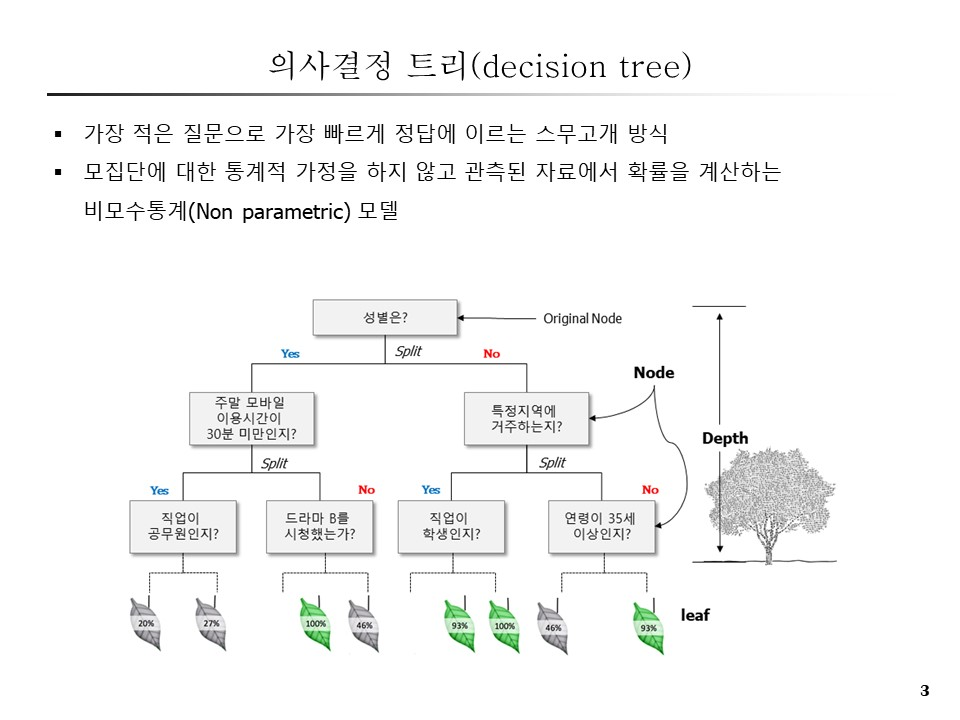

In [7]:
Image(filename='../image/ensemble/슬라이드3.jpg', width=width, height=height)

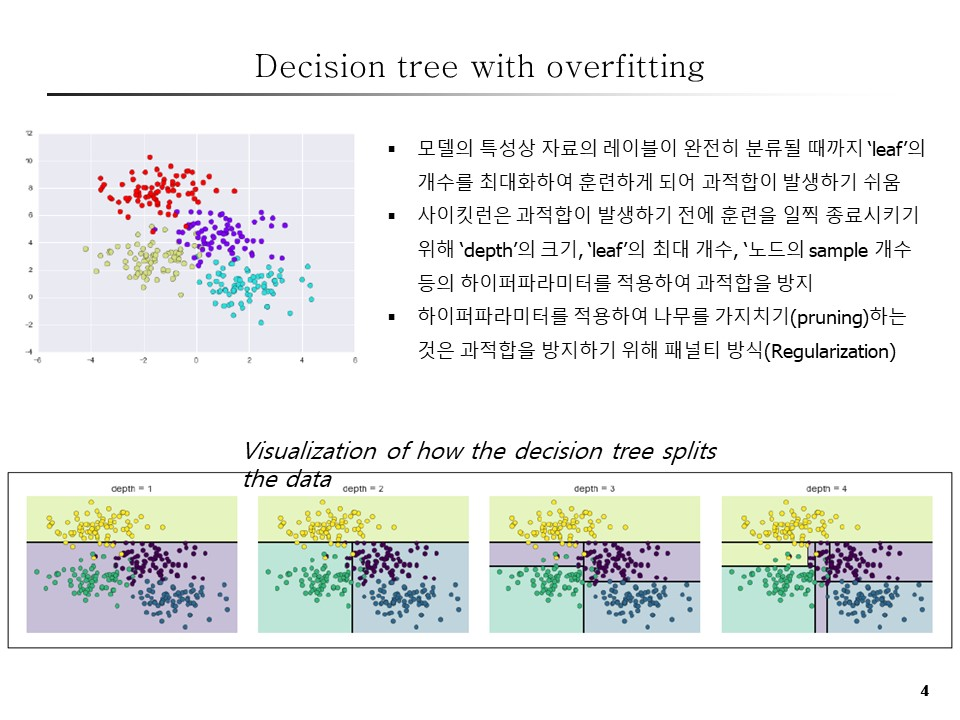

In [8]:
Image(filename='../image/ensemble/슬라이드4.jpg', width=width, height=height)

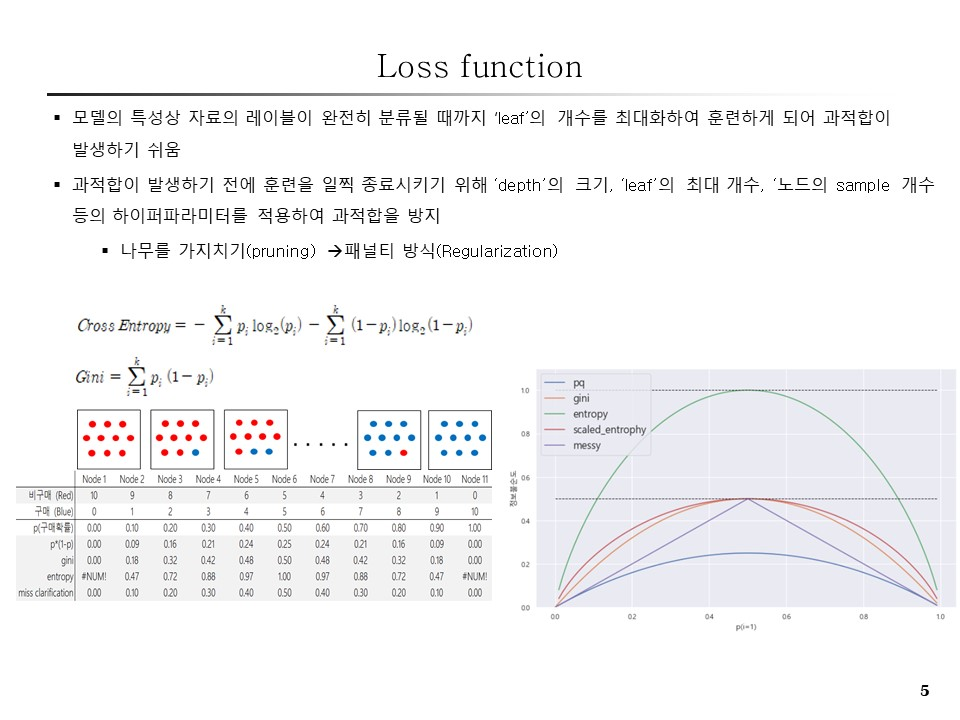

In [9]:
Image(filename='../image/ensemble/슬라이드5.jpg', width=width, height=height)

## loss function

In [10]:
def pq(p):
   return p*(1 - p)

def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def cross_entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def miss_clear(p):
   return 1 - np.max([p, 1 - p])

<Figure size 864x504 with 0 Axes>

(0.0, 1.1)

Text(0.5, 0, 'p(i=1)')

Text(0, 0.5, '정보불순도')

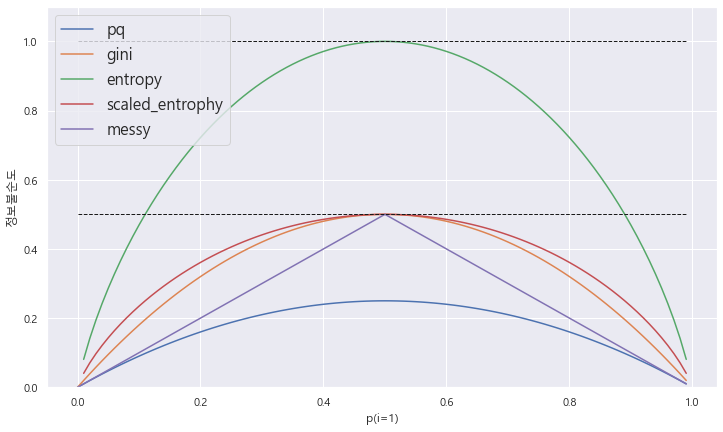

In [11]:
plt.figure(figsize=(12, 7)); plt.rc('legend', fontsize=16)
x = np.arange(0.0, 1.0, 0.01)
plt.plot(x, pq(x), label='pq'); plt.legend()
plt.plot(x, gini(x), label='gini'); plt.legend() # pq*2(이진분류)
plt.plot(x, [cross_entropy(p) if p != 0 else None for p in x],  label='entropy')
plt.legend()
plt.plot(x, cross_entropy(x)*0.5, label='scaled_entrophy'); plt.legend()
plt.plot(x, [miss_clear(i) for i in x], label='messy'); plt.legend()
plt.plot(x, [0.5]*x.shape[0], linewidth=1, color='k', linestyle='--')
plt.plot(x, [1.0]*x.shape[0], linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1]); plt.xlabel('p(i=1)'); plt.ylabel('정보불순도')

## 데이터 읽고 훈련시험 데이터 준비

In [12]:
X = pd.read_pickle('../data/X.pkl') # 특성변수만 반영
y = pd.read_pickle('../data/y.pkl')
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
dt = DecisionTreeClassifier(random_state=11)
dt.fit(X, y)

DecisionTreeClassifier(random_state=11)

### Model interpretability_1. 특성변수 model-based 중요도

랜덤포레스트 모델의 입력변수의 중요도(Impurity 기준)를 X축으로 하여 변수명을 시각화
- '연령’, ‘모바일 평일 이용시간’, ‘모바일 주말 이용시간’ 등이 예측에 크게 영향을 미치고 있다.

In [15]:
dt.feature_importances_

array([0.01968711, 0.01805845, 0.02458363, 0.03058854, 0.0354019 ,
       0.01033749, 0.01256775, 0.0050784 , 0.00066924, 0.01792336,
       0.03543877, 0.25699183, 0.10693147, 0.01195704, 0.11631506,
       0.10200588, 0.02492097, 0.09753369, 0.01753413, 0.02073382,
       0.03474148])

<Figure size 1800x432 with 0 Axes>

Text(0, 0.5, 'Features Importance')

Text(0.5, 1.0, '의사결정트리의 변수 중요도')

([<matplotlib.axis.XTick at 0x2619d137dc0>,
 [Text(0, 0, 'tv4'),
  Text(1, 0, 'tv9'),
  Text(2, 0, 'drama7'),
  Text(3, 0, '지역_경기인천'),
  Text(4, 0, '지역_부산울산경남'),
  Text(5, 0, 'drama3'),
  Text(6, 0, '지역_대구경북'),
  Text(7, 0, 'drama15'),
  Text(8, 0, 'tv15'),
  Text(9, 0, 'drama9'),
  Text(10, 0, 'tv3'),
  Text(11, 0, '연령'),
  Text(12, 0, '인터넷평일'),
  Text(13, 0, '직업_무직기타'),
  Text(14, 0, '모바일주말'),
  Text(15, 0, '모바일평일'),
  Text(16, 0, 'drama8'),
  Text(17, 0, '인터넷주말'),
  Text(18, 0, '성별_여'),
  Text(19, 0, '성별_남'),
  Text(20, 0, 'drama4')])

<BarContainer object of 21 artists>

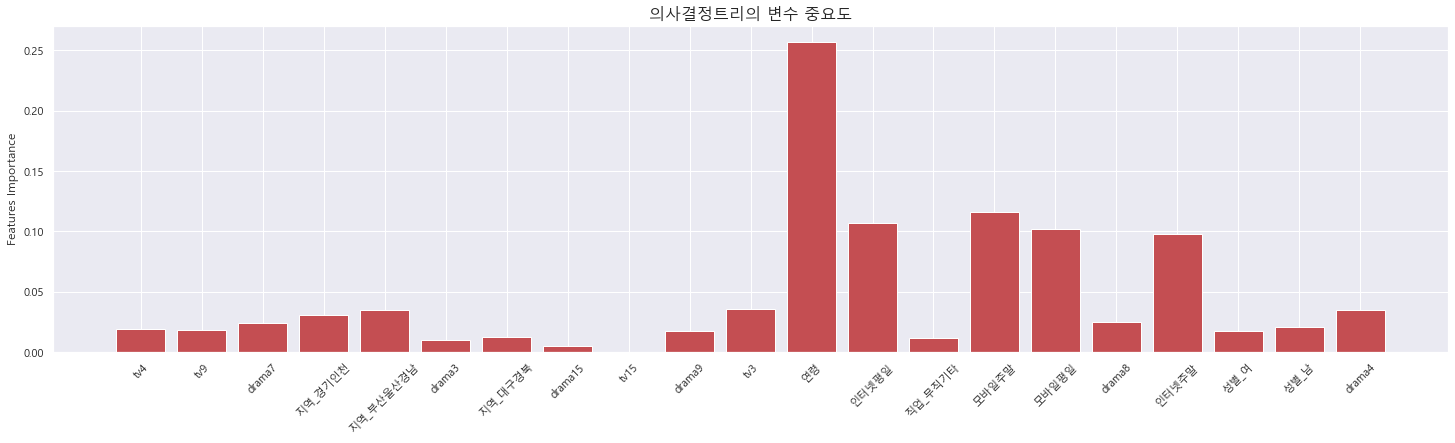

In [16]:
plt.figure(figsize=(25,6)); plt.ylabel('Features Importance')
plt.title('의사결정트리의 변수 중요도', fontsize=16)
plt.xticks(np.arange(X.shape[1]), X.columns, rotation='45')
plt.bar(range(X.shape[1]), dt.feature_importances_, color='r')

In [17]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 11,
 'splitter': 'best'}

### Model interpretability_2. 특성변수 permutation-based 중요도

- 특정 변수의 값을 무작위로 재정렬하여(permutation) 학습하는 경우 모델의 정확도에 영향을 얼마나 주는지를 가리키는 지표
     * model_based’ 중요도의 크기와는 다르다. 사이킷런의 Permutation-based feature importance모듈을 호출
- 예측에 영향을 미치는 입력변수의 중요도가 높은 순서대로 확인

In [18]:
X_test.head()
X_test.iloc[:,0:4].apply(np.random.permutation).head()

,tv4,tv9,drama7,지역_경기인천,지역_부산울산경남,drama3,지역_대구경북,drama15,tv15,drama9,...,연령,인터넷평일,직업_무직기타,모바일주말,모바일평일,drama8,인터넷주말,성별_여,성별_남,drama4
969,0.579234,2.30963,0.782134,0,1,-0.396918,0,-0.089837,-0.067259,-0.293498,...,-1.082076,-0.075924,0,0.544783,0.525604,2.694117,0.082196,0,1,-1.637911
3493,0.579234,-0.43297,0.782134,0,0,-0.396918,0,-0.089837,-0.067259,-0.293498,...,-1.478277,-0.804841,0,-0.338293,-0.863126,-0.371179,0.082196,1,0,0.435808
2821,0.579234,-0.43297,-1.205273,1,0,-0.396918,0,-0.089837,-0.067259,-0.293498,...,-0.685875,-0.804841,0,-0.962722,-0.863126,2.694117,-1.279541,1,0,-1.637911
147,-1.699504,-0.43297,0.782134,0,0,-0.396918,0,-0.089837,-0.067259,-0.293498,...,-0.685875,-0.075924,1,-1.239354,-0.091609,-0.371179,0.763064,0,1,0.435808
88,0.579234,-0.43297,-1.205273,0,0,-0.396918,0,-0.089837,-0.067259,-0.293498,...,-1.082076,-0.075924,0,-0.338293,-0.400216,-0.371179,0.082196,0,1,0.435808


,tv4,tv9,drama7,지역_경기인천
969,-1.699504,-0.43297,0.782134,0
3493,-1.699504,-0.43297,0.782134,0
2821,0.579234,-0.43297,-1.205273,0
147,0.579234,-0.43297,0.782134,0
88,0.579234,-0.43297,-1.205273,0


In [19]:
from sklearn.inspection import permutation_importance
result = permutation_importance(dt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

<Figure size 1800x432 with 0 Axes>

Text(0, 0.5, 'Features Permutation Importance')

Text(0.5, 1.0, '의사결정트리의 변수 Permutation 중요도')

([<matplotlib.axis.XTick at 0x2619d584580>,
 [Text(0, 0, 'tv4'),
  Text(1, 0, 'tv9'),
  Text(2, 0, 'drama7'),
  Text(3, 0, '지역_경기인천'),
  Text(4, 0, '지역_부산울산경남'),
  Text(5, 0, 'drama3'),
  Text(6, 0, '지역_대구경북'),
  Text(7, 0, 'drama15'),
  Text(8, 0, 'tv15'),
  Text(9, 0, 'drama9'),
  Text(10, 0, 'tv3'),
  Text(11, 0, '연령'),
  Text(12, 0, '인터넷평일'),
  Text(13, 0, '직업_무직기타'),
  Text(14, 0, '모바일주말'),
  Text(15, 0, '모바일평일'),
  Text(16, 0, 'drama8'),
  Text(17, 0, '인터넷주말'),
  Text(18, 0, '성별_여'),
  Text(19, 0, '성별_남'),
  Text(20, 0, 'drama4')])

<BarContainer object of 21 artists>

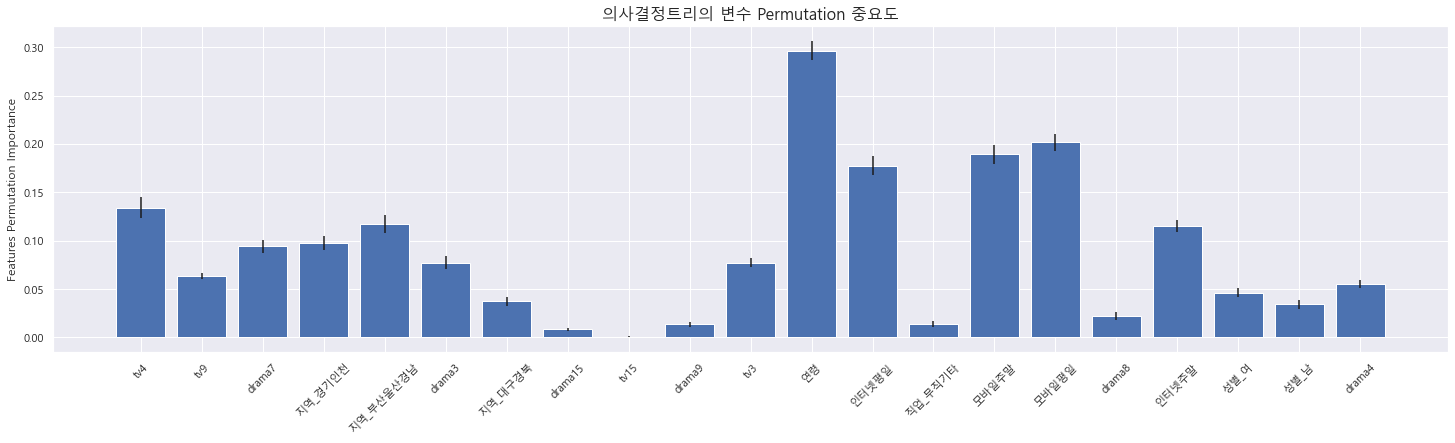

In [20]:
plt.figure(figsize=(25,6)); plt.ylabel('Features Permutation Importance')
plt.title('의사결정트리의 변수 Permutation 중요도', fontsize=16)
plt.xticks(np.arange(X.shape[1]), X.columns, rotation='45')
plt.bar(range(X.shape[1]), forest_importances, yerr=result.importances_std, color='b')

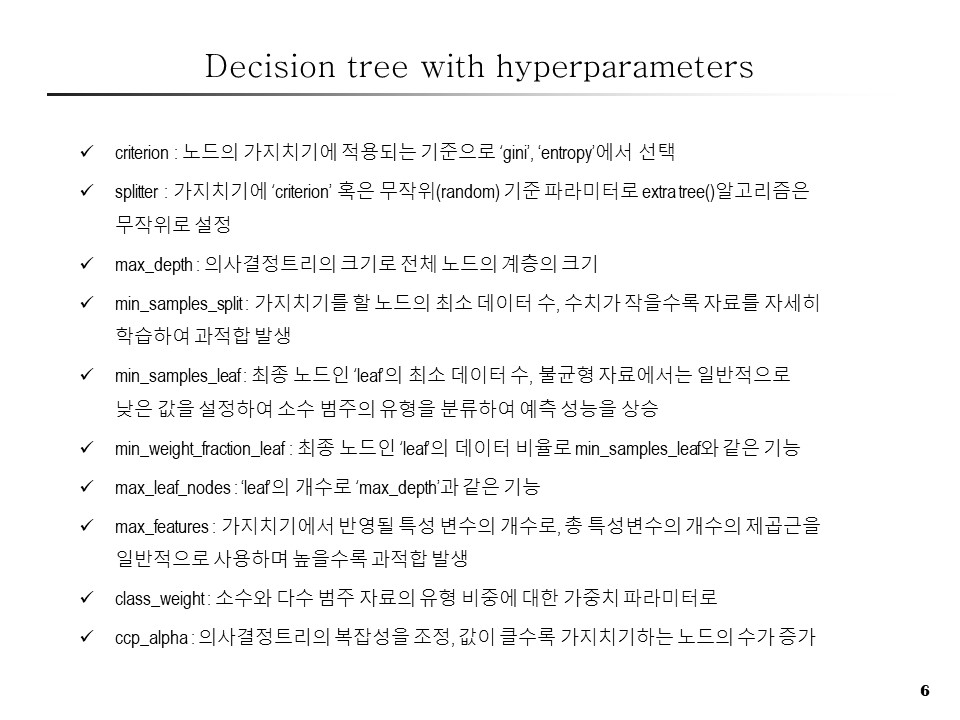

In [21]:
Image(filename='../image/ensemble/슬라이드6.jpg', width=width, height=height)

In [22]:
params = {
    'criterion' :['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : np.arange(1,10),
    'min_samples_split': [0.005, 0.01, 0.05, 0.10],
    'min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [23]:
np.random.seed(1111)
kf = KFold(n_splits=5)
model = DecisionTreeClassifier(random_state=11)
grid = RandomizedSearchCV(model, params, cv=kf, n_iter=500, 
                          scoring = 'recall_macro', verbose =True)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=11),
                   n_iter=500,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [0.005, 0.01, 0.05,
                                                             0.1],
                                        'min_samples_split': [0.005, 0.01, 0.05,
                                                              0.1],
                                        'splitter': ['best', 'random']},
                   scoring='recall_macro', verbose=True)

In [24]:
print('optimal parameter: {}'.format(grid.best_params_))

optimal parameter: {'splitter': 'random', 'min_samples_split': 0.1, 'min_samples_leaf': 0.01, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}


## 중간 학습
- 사용자정의함수 괄호 안의 인자는 사전에 인자를 정하지 않는 경우
     * 일반 인자(*arg)와 키워드 인자(**kwarg)를 사용
- 일반 인자(*arg)와 달리 키워드 인자(**kwarg)는 파이썬의 사전(dictionary)자료 형태인 key와 value를 아는 경우이다

In [25]:
def catch_all(*args, **kwargs):
    print("args =", args)
    print("kwargs =", kwargs)

catch_all(1, 2, 3, 4, a=7, b=5)

args = (1, 2, 3, 4)
kwargs = {'a': 7, 'b': 5}


In [26]:
catch_all('a',keyword=2)

args = ('a',)
kwargs = {'keyword': 2}


In [27]:
catch_all(**{'keyword': 3, 'name': 'ancestor9'})

args = ()
kwargs = {'keyword': 3, 'name': 'ancestor9'}


In [28]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 11,
 'splitter': 'best'}

In [29]:
best_params = grid.best_params_
tuned_params = {item[:]: best_params[item] for item in best_params}
tuned_params

{'splitter': 'random',
 'min_samples_split': 0.1,
 'min_samples_leaf': 0.01,
 'max_features': 'sqrt',
 'max_depth': 8,
 'criterion': 'gini'}

In [30]:
model= DecisionTreeClassifier(random_state=11).set_params(**tuned_params)
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.01,
 'min_samples_split': 0.1,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 11,
 'splitter': 'random'}

In [31]:
model.fit(X_train, y_train)
print("Feature importances:\n{}".format(model.feature_importances_))

DecisionTreeClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=0.01,
                       min_samples_split=0.1, random_state=11,
                       splitter='random')

Feature importances:
[1.02090215e-01 1.33136103e-01 0.00000000e+00 3.51583909e-02
 3.02525312e-01 1.12282211e-01 1.27680178e-01 0.00000000e+00
 0.00000000e+00 1.80885208e-02 0.00000000e+00 0.00000000e+00
 4.94115411e-02 2.11406392e-03 0.00000000e+00 0.00000000e+00
 2.15512244e-04 2.63027116e-03 1.14667681e-01 0.00000000e+00
 0.00000000e+00]


In [32]:
from joblib import dump, load
dump(model, '../output/dt.joblib')

['../output/dt.joblib']

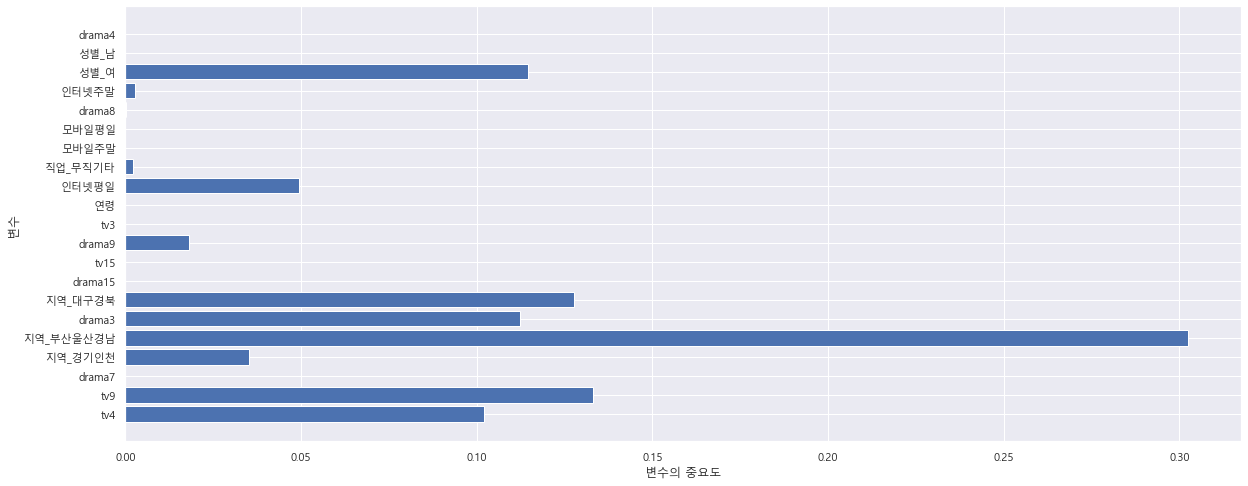

In [33]:
def plot_feature_importances(model):
    fig, ax = plt.subplots(1,1,figsize=(20,8))
    plt.barh(range(X_train.shape[1]), model.feature_importances_, align='center')
    plt.yticks(np.arange(X_train.shape[1]), X_train.columns)
    plt.xlabel('변수의 중요도')
    plt.ylabel('변수')
    plt.savefig('../output/Feature_importance') 
    
plot_feature_importances(model)

In [34]:
y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       522
           1       0.48      0.33      0.40       278

    accuracy                           0.65       800
   macro avg       0.59      0.57      0.57       800
weighted avg       0.62      0.65      0.63       800



### Overfitting을 방지

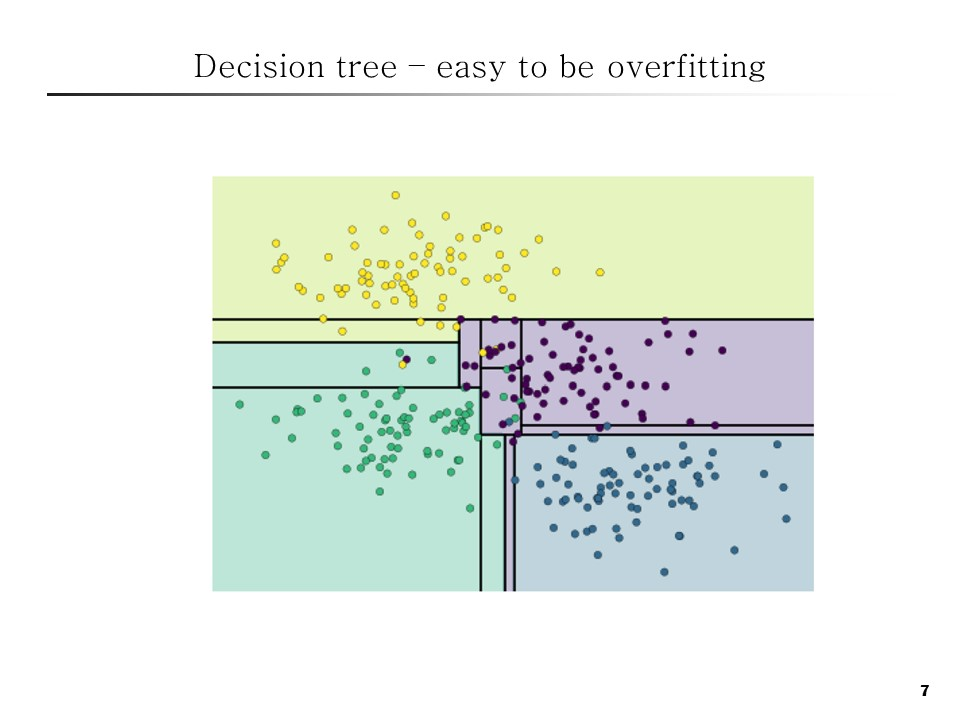

In [35]:
Image(filename='../image/ensemble/슬라이드7.jpg', width=width, height=height)

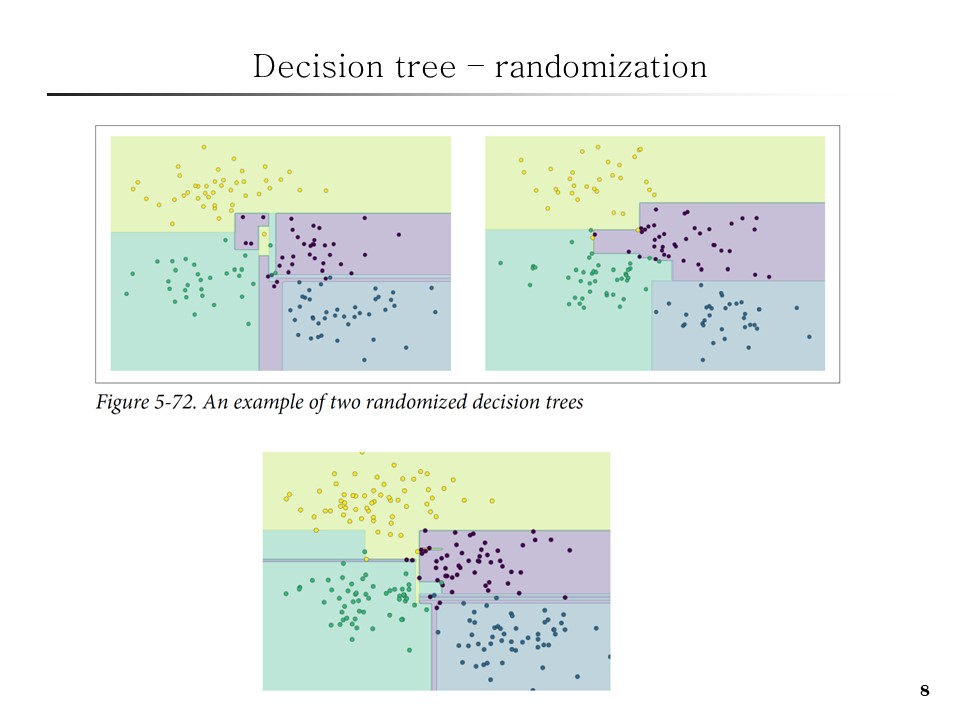

In [36]:
Image(filename='../image/ensemble/슬라이드8.jpg', width=width, height=height)

## Post-Pruning in Decision Tree
https://medium.com/analytics-vidhya/post-pruning-and-pre-pruning-in-decision-tree-561f3df73e65

i. Importing libraries

ii. Modeling without Post-Pruning

In [66]:
X,y=load_breast_cancer(return_X_y=True)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)
clf=DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
y_train_predicted=clf.predict(X_train)
y_test_predicted=clf.predict(X_test)
accuracy_score(y_train,y_train_predicted)
accuracy_score(y_test,y_test_predicted)

DecisionTreeClassifier(random_state=0)

1.0

0.8811188811188811

As we see difeerence between accuracy score of train and test is too high means model is overfitted (because it is accurate for training set but gives large error when we provide test set to the model)

<Figure size 1152x576 with 0 Axes>

[Text(499.54285714285714, 410.71999999999997, 'X[7] <= 0.049\ngini = 0.468\nsamples = 426\nvalue = [159, 267]'),
 Text(318.85714285714283, 362.4, 'X[23] <= 952.9\ngini = 0.095\nsamples = 260\nvalue = [13, 247]'),
 Text(212.57142857142856, 314.08, 'X[13] <= 42.19\ngini = 0.054\nsamples = 252\nvalue = [7, 245]'),
 Text(127.54285714285714, 265.76, 'X[25] <= 0.454\ngini = 0.032\nsamples = 247\nvalue = [4, 243]'),
 Text(85.02857142857142, 217.44, 'X[21] <= 30.145\ngini = 0.024\nsamples = 246\nvalue = [3, 243]'),
 Text(42.51428571428571, 169.12, 'gini = 0.0\nsamples = 215\nvalue = [0, 215]'),
 Text(127.54285714285714, 169.12, 'X[14] <= 0.004\ngini = 0.175\nsamples = 31\nvalue = [3, 28]'),
 Text(85.02857142857142, 120.80000000000001, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(170.05714285714285, 120.80000000000001, 'X[1] <= 23.2\ngini = 0.067\nsamples = 29\nvalue = [1, 28]'),
 Text(127.54285714285714, 72.48000000000002, 'X[1] <= 22.385\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text

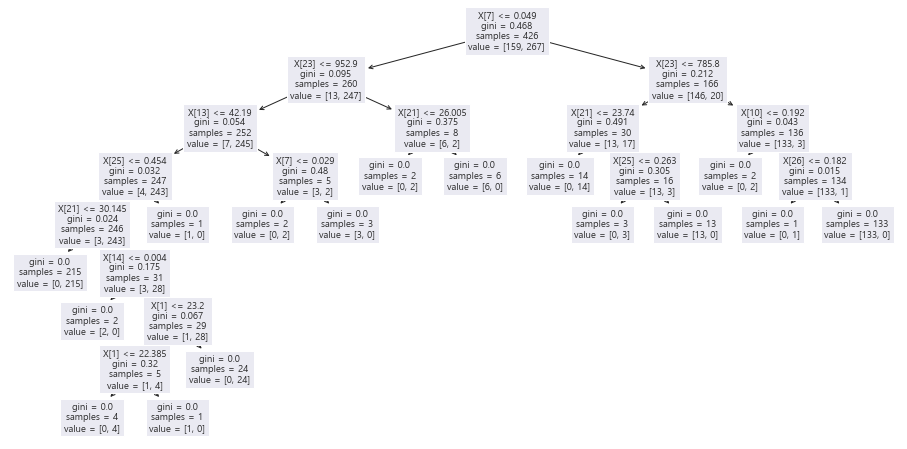

In [65]:
from sklearn import tree
plt.figure(figsize=(16,8))
tree.plot_tree(clf)
plt.show()

iii. Post-Pruning operation :
- Here we use cost_complexity_pruning technique to prune the branches of decision tree.

In [69]:
path=clf.cost_complexity_pruning_path(X_train,y_train)
#path variable gives two things ccp_alphas and impurities
ccp_alphas,impurities=path.ccp_alphas,path.impurities
print("ccp alpha wil give list of values :\n",ccp_alphas)
print("***********************************************************")
print("Impurities in Decision Tree :\n",impurities)

ccp alpha wil give list of values :
 [0.         0.00226647 0.00464743 0.0046598  0.0056338  0.00704225
 0.00784194 0.00911402 0.01144366 0.018988   0.02314163 0.03422475
 0.32729844]
***********************************************************
Impurities in Decision Tree :
 [0.         0.00453294 0.01847522 0.02313502 0.02876883 0.03581108
 0.04365302 0.05276704 0.0642107  0.0831987  0.10634033 0.14056508
 0.46786352]


ccp_alphas gives minimum leaf value of decision tree and each ccp_aphas will create different - different classifier and choose best out of it.ccp_alphas will be added as a parameter in DecisionTreeClassifier() .

In [70]:
clfs=[]   #will store all the models here
for ccp_alpha in ccp_alphas:
    clf=DecisionTreeClassifier(random_state=0,ccp_alpha=ccp_alpha)
    clf.fit(X_train,y_train)
    clfs.append(clf)
print("Last node in Decision tree is {} and ccp_alpha for last node is {}".format(clfs[-1].tree_.node_count,ccp_alphas[-1]))

DecisionTreeClassifier(random_state=0)

DecisionTreeClassifier(ccp_alpha=0.0022664723976040134, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.004647426339100881, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.004659799593581376, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.005633802816901408, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.007042253521126761, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.007841938420144537, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.009114019793328328, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.011443661971830986, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.018988002086593604, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.023141627543035996, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.03422474765119576, random_state=0)

DecisionTreeClassifier(ccp_alpha=0.3272984419327777, random_state=0)

Last node in Decision tree is 1 and ccp_alpha for last node is 0.3272984419327777


Visualizing the accuracy score for train and test set.

Text(0.5, 0, 'alpha')

Text(0, 0.5, 'accuracy')

Text(0.5, 1.0, 'Accuracy vs alpha for training and testing sets')

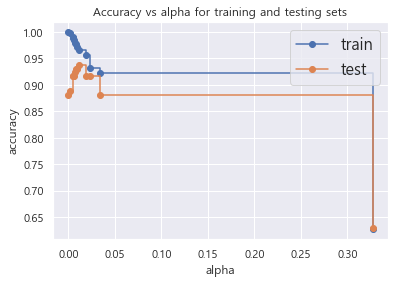

In [71]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
ax.legend()
plt.show()

If we folow bias and variance tradeoff we will choose that point which will have low bias(low training erro) and low variance(low test error).Here we get that point at a value of alpha=0.02.

DecisionTreeClassifier(ccp_alpha=0.02, random_state=0)

<Figure size 864x576 with 0 Axes>

[Text(267.84000000000003, 380.52, 'X[7] <= 0.049\ngini = 0.468\nsamples = 426\nvalue = [159, 267]'),
 Text(133.92000000000002, 271.8, 'gini = 0.095\nsamples = 260\nvalue = [13, 247]'),
 Text(401.76000000000005, 271.8, 'X[23] <= 785.8\ngini = 0.212\nsamples = 166\nvalue = [146, 20]'),
 Text(267.84000000000003, 163.07999999999998, 'X[21] <= 23.74\ngini = 0.491\nsamples = 30\nvalue = [13, 17]'),
 Text(133.92000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(401.76000000000005, 54.360000000000014, 'gini = 0.305\nsamples = 16\nvalue = [13, 3]'),
 Text(535.6800000000001, 163.07999999999998, 'gini = 0.043\nsamples = 136\nvalue = [133, 3]')]

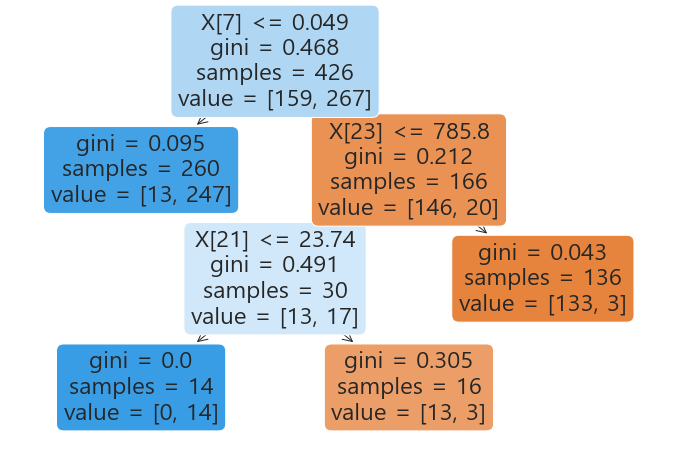

In [73]:
clf=DecisionTreeClassifier(random_state=0,ccp_alpha=0.02)
clf.fit(X_train,y_train)
plt.figure(figsize=(12,8))
tree.plot_tree(clf,rounded=True,filled=True)
plt.show()

Here we are able to prune infinitely grown tree.let’s check the accuracy score again.

In [74]:
accuracy_score(y_test,clf.predict(X_test))

0.916083916083916

## Pre-Pruning :
- This technique is used before construction of decision tree.
- Pre-Pruning can be done using Hyperparameter tuning.
- Overcome the overfitting issue.

what is Hyperparameter Tuning ?
Lets’ take an example of Decision tree. When we build a DT model we don’t have any idea about which criterion (“gini” or “entropy”) ,what min_depth , what min_samples_split etc will give better model so to break this kind of ambiguity we use hyperparameter tuning in which we take a range of value for each parameters and whichever parameteric value will be best we will feed that particular value into DecisionTreeClassifier() .

In [80]:
grid_param={"criterion":["gini","entropy"],
             "splitter":["best","random"],
             "max_depth":range(2,50,1),
             "min_samples_leaf":range(1,15,1),
             "min_samples_split":range(2,20,1) 
            }
grid_search=RandomizedSearchCV(clf, grid_param, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.02,
                                                    random_state=0),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 50),
                                        'min_samples_leaf': range(1, 15),
                                        'min_samples_split': range(2, 20),
                                        'splitter': ['best', 'random']})

{'splitter': 'random', 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_depth': 16, 'criterion': 'entropy'}


DecisionTreeClassifier(criterion='entropy', max_depth=16, min_samples_leaf=6,
                       min_samples_split=9, splitter='random')

<Figure size 1440x864 with 0 Axes>

[Text(359.7631578947368, 616.08, 'X[0] <= 12.456\nentropy = 0.953\nsamples = 426\nvalue = [159, 267]'),
 Text(176.21052631578948, 543.6, 'X[7] <= 0.055\nentropy = 0.265\nsamples = 155\nvalue = [7, 148]'),
 Text(117.47368421052632, 471.12, 'X[7] <= 0.032\nentropy = 0.105\nsamples = 145\nvalue = [2, 143]'),
 Text(58.73684210526316, 398.64000000000004, 'entropy = 0.0\nsamples = 121\nvalue = [0, 121]'),
 Text(176.21052631578948, 398.64000000000004, 'X[10] <= 0.345\nentropy = 0.414\nsamples = 24\nvalue = [2, 22]'),
 Text(117.47368421052632, 326.16, 'entropy = 0.0\nsamples = 16\nvalue = [0, 16]'),
 Text(234.94736842105263, 326.16, 'entropy = 0.811\nsamples = 8\nvalue = [2, 6]'),
 Text(234.94736842105263, 471.12, 'entropy = 1.0\nsamples = 10\nvalue = [5, 5]'),
 Text(543.3157894736842, 543.6, 'X[27] <= 0.086\nentropy = 0.989\nsamples = 271\nvalue = [152, 119]'),
 Text(352.42105263157896, 471.12, 'X[2] <= 94.728\nentropy = 0.194\nsamples = 67\nvalue = [2, 65]'),
 Text(293.6842105263158, 398.640

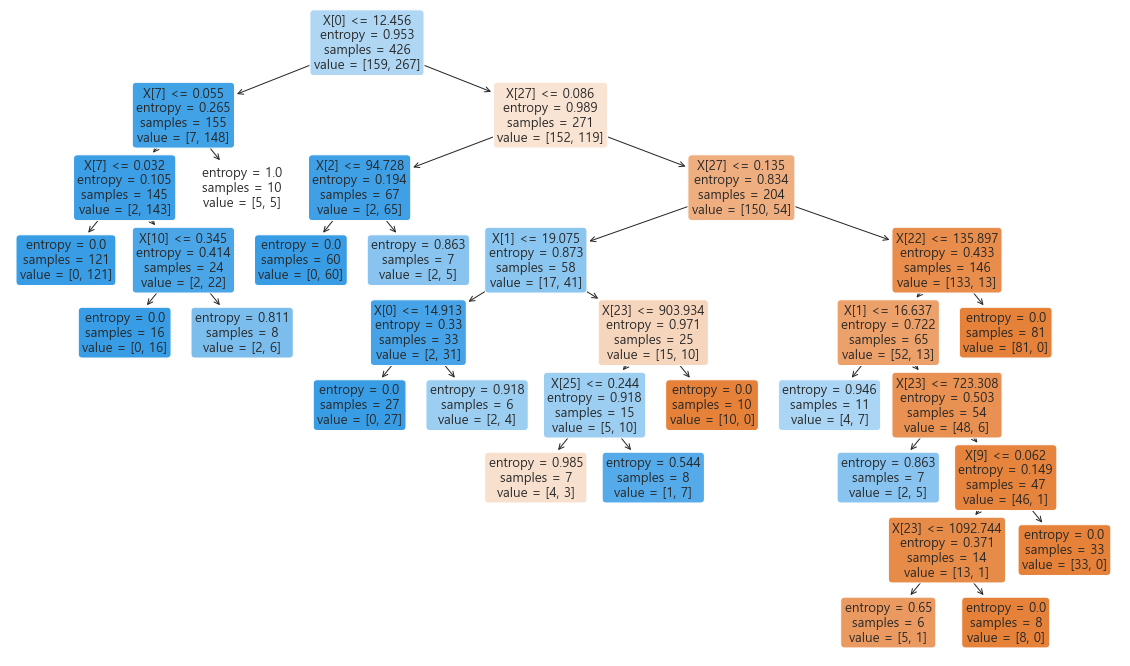

In [84]:
print(grid_search.best_params_)

best_params = grid_search.best_params_
tuned_params = {item[:]: best_params[item] for item in best_params}

clf= DecisionTreeClassifier().set_params(**tuned_params)
# clf=DecisionTreeClassifier(criterion= 'gini',max_depth= 17,min_samples_leaf= 3,min_samples_split= 12,splitter= 'random')
clf.fit(X_train,y_train)
plt.figure(figsize=(20,12))
tree.plot_tree(clf,rounded=True,filled=True)
plt.show()

## 예제
https://jeongmin-lee.tistory.com/85

  0%|          | 0/14 [00:00<?, ?it/s]

DecisionTreeClassifier(max_depth=1)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

DecisionTreeClassifier(max_depth=2)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

DecisionTreeClassifier(max_depth=3)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

DecisionTreeClassifier(max_depth=4)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

DecisionTreeClassifier(max_depth=5)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

DecisionTreeClassifier(max_depth=6)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

DecisionTreeClassifier(max_depth=7)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

DecisionTreeClassifier(max_depth=8)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

DecisionTreeClassifier(max_depth=9)

DecisionTreeClassifier(criterion='entropy', max_depth=9)

DecisionTreeClassifier(max_depth=10)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

DecisionTreeClassifier(max_depth=11)

DecisionTreeClassifier(criterion='entropy', max_depth=11)

DecisionTreeClassifier(max_depth=12)

DecisionTreeClassifier(criterion='entropy', max_depth=12)

DecisionTreeClassifier(max_depth=13)

DecisionTreeClassifier(criterion='entropy', max_depth=13)

DecisionTreeClassifier(max_depth=14)

DecisionTreeClassifier(criterion='entropy', max_depth=14)

<Figure size 1080x576 with 0 Axes>

Text(0.5, 0, 'Depth')

Text(0, 0.5, 'Accuracy')

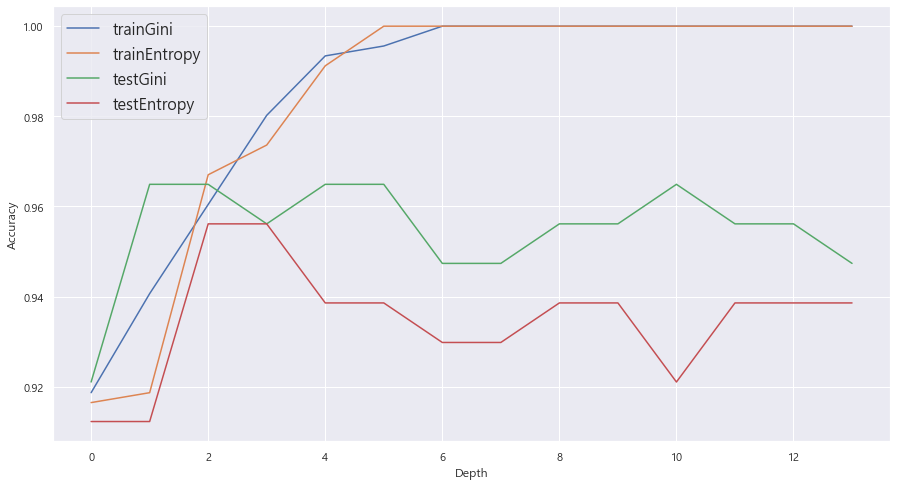

In [38]:
# 데이터 불러오기
from sklearn.datasets import load_breast_cancer
# 데이터 시각화를 위한 모듈
import matplotlib.pyplot as plt
# 데이터를 train과 test로 나눠주는 모듈
from sklearn.model_selection import train_test_split
# DT알고리즘 
from sklearn.tree import DecisionTreeClassifier
# 상태 진행 바 모듈
from tqdm import tqdm_notebook

np.random.seed(11) # random seed에 따라 결과가 달라짐
cancer = load_breast_cancer()

# train 데이터셋과 test 데이터셋 구성
trainX, testX, trainY, testY = \
    train_test_split(cancer['data'], cancer['target'], test_size=0.2)

trainGini = []
testGini = []
trainEntropy = []
testEntropy = []

for k in tqdm_notebook(range(1, 15)):
    # DT으로 train 데이터를 학습 (지니계수 사용)
    dt = DecisionTreeClassifier(criterion='gini', max_depth=k)
    dt.fit(trainX, trainY)
    
    # 정확도 측정
    trainGini.append(dt.score(trainX, trainY))
    testGini.append(dt.score(testX, testY))
    
    # DT으로 train 데이터를 학습 (엔트로피 사용)
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=k)
    dt.fit(trainX, trainY)
    
    # 정확도 측정
    trainEntropy.append(dt.score(trainX, trainY))
    testEntropy.append(dt.score(testX, testY))
    

plt.figure(figsize=(15, 8))
plt.plot(trainGini, label='trainGini')
plt.plot(trainEntropy, label='trainEntropy')
plt.plot(testGini, label='testGini')
plt.plot(testEntropy, label='testEntropy')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

## Decision Tree 알고리즘을 사용해 income 데이터 분류하기 사전 가지치기(pre-pruning)

  0%|          | 0/19 [00:00<?, ?it/s]

DecisionTreeClassifier(max_depth=1)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

depth = 1 done.


DecisionTreeClassifier(max_depth=2)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

depth = 2 done.


DecisionTreeClassifier(max_depth=3)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

depth = 3 done.


DecisionTreeClassifier(max_depth=4)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

depth = 4 done.


DecisionTreeClassifier(max_depth=5)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

depth = 5 done.


DecisionTreeClassifier(max_depth=6)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

depth = 6 done.


DecisionTreeClassifier(max_depth=7)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

depth = 7 done.


DecisionTreeClassifier(max_depth=8)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

depth = 8 done.


DecisionTreeClassifier(max_depth=9)

DecisionTreeClassifier(criterion='entropy', max_depth=9)

depth = 9 done.


DecisionTreeClassifier(max_depth=10)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

depth = 10 done.


DecisionTreeClassifier(max_depth=11)

DecisionTreeClassifier(criterion='entropy', max_depth=11)

depth = 11 done.


DecisionTreeClassifier(max_depth=12)

DecisionTreeClassifier(criterion='entropy', max_depth=12)

depth = 12 done.


DecisionTreeClassifier(max_depth=13)

DecisionTreeClassifier(criterion='entropy', max_depth=13)

depth = 13 done.


DecisionTreeClassifier(max_depth=14)

DecisionTreeClassifier(criterion='entropy', max_depth=14)

depth = 14 done.


DecisionTreeClassifier(max_depth=15)

DecisionTreeClassifier(criterion='entropy', max_depth=15)

depth = 15 done.


DecisionTreeClassifier(max_depth=16)

DecisionTreeClassifier(criterion='entropy', max_depth=16)

depth = 16 done.


DecisionTreeClassifier(max_depth=17)

DecisionTreeClassifier(criterion='entropy', max_depth=17)

depth = 17 done.


DecisionTreeClassifier(max_depth=18)

DecisionTreeClassifier(criterion='entropy', max_depth=18)

depth = 18 done.


DecisionTreeClassifier(max_depth=19)

DecisionTreeClassifier(criterion='entropy', max_depth=19)

depth = 19 done.


<Figure size 1080x576 with 0 Axes>

Text(0.5, 0, 'Depth')

Text(0, 0.5, 'Accuracy')

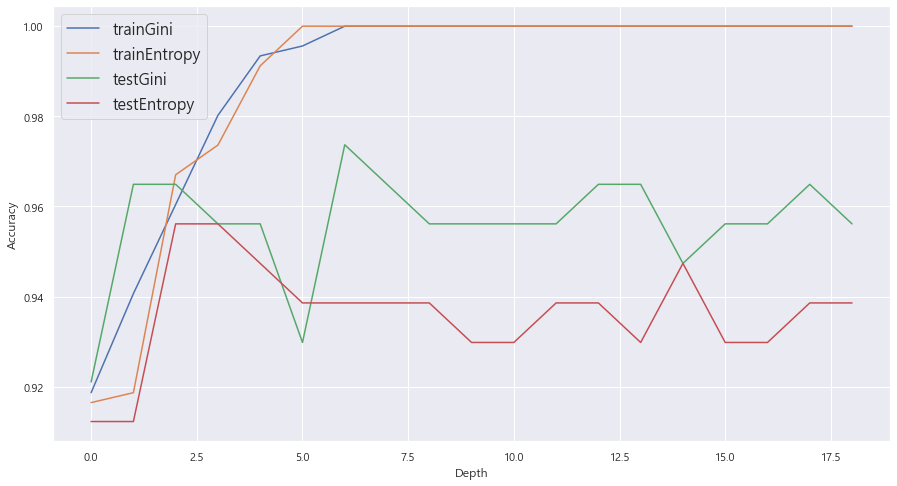

DecisionTreeClassifier(max_depth=7)

시험 데이터의 정확도 = 0.9649
최적 트리의 depth = 7


In [62]:
trainGini = []
testGini = []
trainEntropy = []
testEntropy = []
depth = []

# 사전 가지치기
for k in tqdm_notebook(range(1, 20)):
    dt = DecisionTreeClassifier(criterion='gini', max_depth=k)
    dt.fit(trainX, trainY)
    
    trainGini.append(dt.score(trainX, trainY))
    testGini.append(dt.score(testX, testY))
    
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=k)
    dt.fit(trainX, trainY)
    
    trainEntropy.append(dt.score(trainX, trainY))
    testEntropy.append(dt.score(testX, testY))
    
    depth.append(k)
    print('depth = %d done.' % k)

plt.figure(figsize=(15, 8))
plt.plot(trainGini, label='trainGini')
plt.plot(trainEntropy, label='trainEntropy')
plt.plot(testGini, label='testGini')
plt.plot(testEntropy, label='testEntropy')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

# 정확도가 가장 큰 최적의 depth를 찾는다
nDepth = depth[np.argmax(testGini)]

# opt_alpha를 적용한 tree를 사용한다.
dt = DecisionTreeClassifier(max_depth = nDepth)
dt.fit(trainX, trainY)
print('시험 데이터의 정확도 = %.4f' % dt.score(testX, testY))
print('최적 트리의 depth = %d' % nDepth)

## Decision Tree 알고리즘을 사용해 데이터 분류하기 사후 가지치기(post-pruning)

<Figure size 864x288 with 0 Axes>

Text(0.5, 0, 'effective alpha')

Text(0, 0.5, 'total impurity of leaves')

Text(0.01, 0.12, 'alpha가 증가할수록 불순도가 증가한다.')

Text(0.5, 1.0, 'Total impurity vs effective alpha for training set')

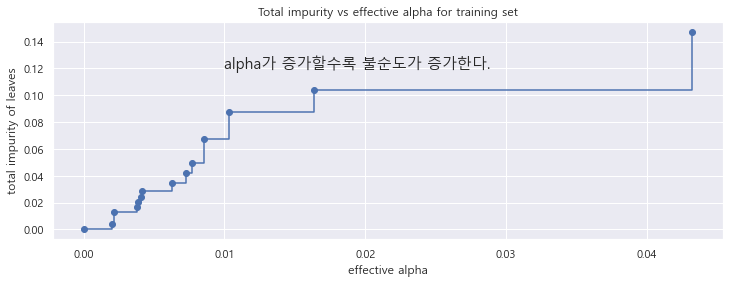

In [47]:
path = DecisionTreeClassifier().cost_complexity_pruning_path(trainX, trainY)
# alpha값과 error값을 리턴해줌
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(12,4))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
plt.xlabel('effective alpha')
plt.ylabel('total impurity of leaves')
plt.text(0.01, 0.12, 'alpha가 증가할수록 불순도가 증가한다.', fontsize=15)
plt.title('Total impurity vs effective alpha for training set')

DecisionTreeClassifier(ccp_alpha=0.002040816326530613)

DecisionTreeClassifier(ccp_alpha=0.0021797874256890724)

DecisionTreeClassifier(ccp_alpha=0.003767660910518054)

DecisionTreeClassifier(ccp_alpha=0.0038461538461538464)

DecisionTreeClassifier(ccp_alpha=0.004057480980557902)

DecisionTreeClassifier(ccp_alpha=0.004151404151404152)

DecisionTreeClassifier(ccp_alpha=0.006279434850863423)

DecisionTreeClassifier(ccp_alpha=0.007245501750996255)

DecisionTreeClassifier(ccp_alpha=0.007705533608202354)

DecisionTreeClassifier(ccp_alpha=0.008573184864369572)

마지막 tree의 노드 개수  = 11
마지막 tree의 alpha  = 0.0086
마지막 tree의 depth  = 4


<Figure size 864x288 with 0 Axes>

Text(0.5, 0, 'ccp_alphas')

Text(0, 0.5, 'node_counts')

Text(0.004, 30, 'alpha가 증가할수록 leaf-node의 개수가 감소한다.\n Tree가 단순해진다(underfitting).')

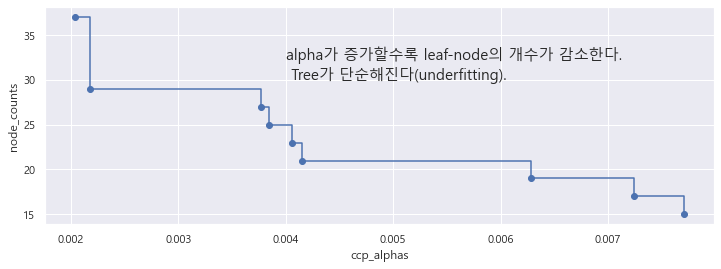

In [53]:
# ccp_alphas가 너무 작은 것은 제외한다
ccp_alphas = ccp_alphas[np.where(ccp_alphas>0.0001)]

clfs = []
for i, ccp_alpha in enumerate(ccp_alphas):
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(trainX, trainY)
    clfs.append(clf)

#     print('%d) ccp_alphas = %.4f done.' % (i, ccp_alpha))

print('마지막 tree의 노드 개수  = %d' % clfs[-1].tree_.node_count)
print('마지막 tree의 alpha  = %.4f' % ccp_alphas[-1])
print('마지막 tree의 depth  = %d' % clfs[-1].tree_.max_depth)

# 마지막 tree는 depth = 0이므로 제외한다.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# ccp_alphas가 증가할수록 node개수와 depth가 감소하는 것을 확인한다.
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

plt.figure(figsize=(12,4))
plt.plot(ccp_alphas, node_counts, marker='o', drawstyle='steps-post')
plt.xlabel('ccp_alphas')
plt.ylabel('node_counts')
plt.text(0.004, 30, 'alpha가 증가할수록 leaf-node의 개수가 감소한다.\n Tree가 단순해진다(underfitting).', fontsize=15)
plt.show()

<Figure size 864x288 with 0 Axes>

Text(0.5, 0, 'ccp_alphas')

Text(0, 0.5, 'depth')

Text(0.005, 6, 'alpha가 증가할수록 \ntree의 depth가 얕아진다(underfitting).')

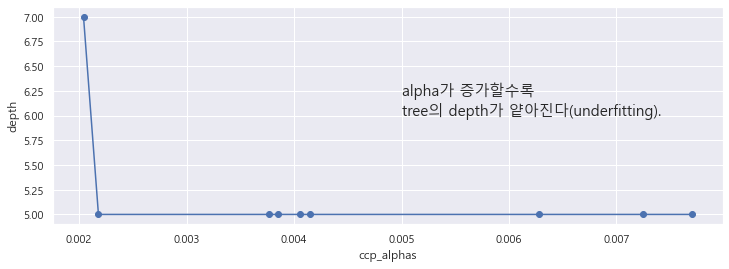

In [58]:
plt.figure(figsize=(12,4))
plt.plot(ccp_alphas, depth, marker='o')
plt.xlabel('ccp_alphas')
plt.ylabel('depth')
plt.text(0.005, 6, 'alpha가 증가할수록 \ntree의 depth가 얕아진다(underfitting).', fontsize=15)
plt.show()

<Figure size 864x360 with 0 Axes>

Text(0.5, 0, 'ccp_alphas')

Text(0, 0.5, 'score')

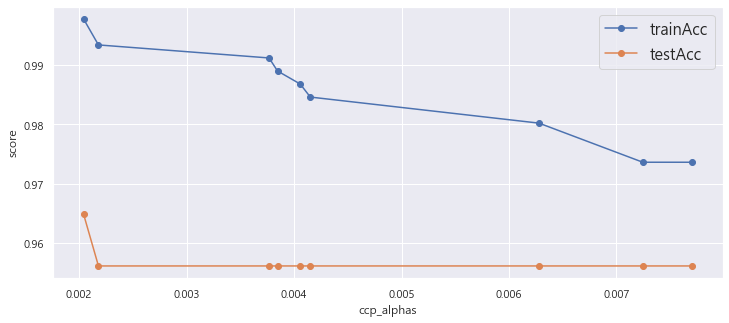

DecisionTreeClassifier(ccp_alpha=0.002040816326530613)

시험 데이터의 정확도 = 0.9474
Optimal alpha = 0.00204082


In [59]:
# ccp_alphas를 적용한 tree들 (clfs)로 score를 계산한다.
# clfs는 앞 부분 n개만 사용한다. 뒷 부분은 alpha가 너무 크기 때문에 제외한다.
n=70
train_scores = [clf.score(trainX, trainY) for clf in clfs[:n]]
test_scores = [clf.score(testX, testY) for clf in clfs[:n]]

plt.figure(figsize=(12,5))
plt.plot(ccp_alphas[:n], train_scores[:n], marker='o', label='trainAcc')
plt.plot(ccp_alphas[:n], test_scores[:n], marker='o', label='testAcc')
plt.xlabel('ccp_alphas')
plt.ylabel('score')
plt.legend()
plt.show()

# test_scores[:n]중 가장 큰 최적 alpha를 찾는다.
opt_alpha = ccp_alphas[np.argmax(test_scores[:n])]

# opt_alpha를 적용한 tree를 사용한다.
dt = DecisionTreeClassifier(ccp_alpha=opt_alpha)
dt.fit(trainX, trainY)

print('시험 데이터의 정확도 = %.4f' % dt.score(testX, testY))
print('Optimal alpha = %.8f' % opt_alpha)

# End